# Transfer Learning
A Convolutional Neural Network (CNN) for image classification is made up of multiple layers that extract features, such as edges, corners, etc; and then use a final fully-connected layer to classify objects based on these features. You can visualize this like this:

<table>
    <tr><td rowspan=2 style='border: 1px solid black;'>&#x21d2;</td><td style='border: 1px solid black;'>Convolutional Layer</td><td style='border: 1px solid black;'>Pooling Layer</td><td style='border: 1px solid black;'>Convolutional Layer</td><td style='border: 1px solid black;'>Pooling Layer</td><td style='border: 1px solid black;'>Fully Connected Layer</td><td rowspan=2 style='border: 1px solid black;'>&#x21d2;</td></tr>
    <tr><td colspan=4 style='border: 1px solid black; text-align:center;'>Feature Extraction</td><td style='border: 1px solid black; text-align:center;'>Classification</td></tr>
</table>

*Transfer Learning* is a technique where you can take an existing trained model and re-use its feature extraction layers, replacing its final classification layer with a fully-connected layer trained on your own custom images. With this technique, your model benefits from the feature extraction training that was performed on the base model (which may have been based on a larger training dataset than you have access to) to build a classification model for your own specific set of object classes.

How does this help? Well, think of it this way. Suppose you take a professional tennis player and a complete beginner, and try to teach them both how to play raquetball. It's reasonable to assume that the professional tennis player will be easier to train, because many of the underlying skills involved in raquetball are already learned. Similarly, a pre-trained CNN model may be easier to train to classify specific set of objects because it's already learned how to identify the features of common objects, such as edges and corners. Fundamentally, a pre-trained model can be a great way to produce an effective classifier even when you have limited data with which to train it.

In this notebook, we'll see how to implement transfer learning for a classification model using PyTorch.

> **Important**:The base model used in this exercise is large, and training is resource-intensive. Before running the code in this notebook, shut down all other notebooks in this library (In each open notebook other than this one, on the **File** menu, click **Close and Halt**). If you experience and Out-of-Memory (OOM) error when running code in this notebook, shut down this entire library, and then reopen it and open only this notebook.

## Using Transfer Learning to Train a CNN

First, we'll import the latest version of PyTorch and prepare to load our training data.

> *Note: The following `pip install` commands install the CPU-based version of PyTorch on Linux, which is appropriate for the Azure Notebooks environment. For instructions on how to install the PyTorch and TorchVision packages on your own system, see https://pytorch.org/get-started/locally/*

In [1]:
# Install PyTorch
#!pip install https://download.pytorch.org/whl/cpu/torch-1.0.1.post2-cp36-cp36m-linux_x86_64.whl
#!pip install torchvision

# Import PyTorch libraries
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import os

print("Libraries imported - ready to use PyTorch", torch.__version__)

Libraries imported - ready to use PyTorch 1.3.1


### Load and Prepare the Data
Before we can train the model to classify images based on our shape classes, we need to prepare the training data. PyTorch includes functions for loading and transforming data. We'll use these to create an iterative loader for training data, and a second iterative loader for test data (which we'll use to validate the trained model). The loaders will transform the image data to match the format used to train the original resnet CNN model, and finally convert the image data into *tensors*, which are the core data structure used in PyTorch.

Run the following cell to define the data loaders, and then load the first batch of 32 training images and display them along with their class labels.

In [2]:
# Function to ingest data using training and test loaders
def load_dataset(data_path):
    
    # Resize to 256 x 256, center-crop to 224x224 (to match the resnet image size), and convert to Tensor
    transformation = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
    ])

    # Load all of the images, transforming them
    full_dataset = torchvision.datasets.ImageFolder(
        root=data_path,
        transform=transformation
    )
    
    # Split into training (70%) and testing (30%) datasets)
    train_size = int(0.7 * len(full_dataset))
    test_size = len(full_dataset) - train_size
    train_dataset, test_dataset = torch.utils.data.random_split(full_dataset, [train_size, test_size])
    
    # define a loader for the training data we can iterate through in 32-image batches
    train_loader = torch.utils.data.DataLoader(
        train_dataset,
        batch_size=15,
        num_workers=0,
        shuffle=False
    )
    
    # define a loader for the testing data we can iterate through in 32-image batches
    test_loader = torch.utils.data.DataLoader(
        test_dataset,
        batch_size=15,
        num_workers=0,
        shuffle=False
    )
        
    return train_loader, test_loader


import os 

# The images are in a folder named 'shapes/training'
training_folder_name = '../data/shapes/training'

# The folder contains a subfolder for each class of shape
classes = sorted(os.listdir(training_folder_name))
print(classes)

# Get the iterative dataloaders for test and training data
train_loader, test_loader = load_dataset(training_folder_name)
print("Data loaders ready to read", training_folder_name)

['circle', 'square', 'triangle']
Data loaders ready to read ../data/shapes/training


### Download a trained model to user as a base
The ***resnet*** model is an CNN-based image classifier that has been pre-trained using a huge dataset containing thousands of images of many kinds of object. We'll download the trained model, excluding its final linear layer, and freeze the convolutional layers to retain the trained weights. Then we'll add a new linear layer that will map the features extracted by the convolutional layers to the classes of our shape images.

In [3]:
model_resnet = torchvision.models.resnet18(pretrained=True)
for param in model_resnet.parameters():
    param.requires_grad = False

num_ftrs = model_resnet.fc.in_features
model_resnet.fc = nn.Linear(num_ftrs, len(classes))

# Now print the full model, which will include the layers of the base model plus the linear layer we added
print(model_resnet)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to C:\Users\Dennis Lam/.cache\torch\checkpoints\resnet18-5c106cde.pth
100%|█████████████████████████████████████████████████████████████████████████████| 44.7M/44.7M [00:07<00:00, 6.41MB/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

### Train the Model
With the layers of the CNN defined, we're ready to train the top layer using our image data. This will take a considerable amount of time on a CPU due to the complexity of the base model, so we'll train the model over only one epoch.

In [4]:
def train(model, device, train_loader, optimizer, epoch):
    # Set the model to training mode
    model.train()
    train_loss = 0
    print("Epoch:", epoch)
    # Process the images in batches
    for batch_idx, (data, target) in enumerate(train_loader):
        # Use the CPU or GPU as appropriate
        data, target = data.to(device), target.to(device)
        
        # Reset the optimizer
        optimizer.zero_grad()
        
        # Push the data forward through the model layers
        output = model(data)
        
        # Get the loss
        loss = loss_criteria(output, target)

        # Keep a running total
        train_loss += loss.item()
        
        # Backpropagate
        loss.backward()
        optimizer.step()
        
        # Print metrics so we see some progress
        print('\tTraining batch {} Loss: {:.6f}'.format(batch_idx + 1, loss.item()))
            
    # return average loss for the epoch
    avg_loss = train_loss / batch_idx+1
    print('Training set: Average loss: {:.6f}'.format(avg_loss))
    return avg_loss
            
            
def test(model, device, test_loader):
    # Switch the model to evaluation mode (so we don't backpropagate or drop)
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        batch_count = 0
        for data, target in test_loader:
            batch_count += 1
            data, target = data.to(device), target.to(device)
            
            # Get the predicted classes for this batch
            output = model(data)
            
            # Calculate the loss for this batch
            test_loss += loss_criteria(output, target).item()
            
            # Calculate the accuracy for this batch
            _, predicted = torch.max(output.data, 1)
            correct += torch.sum(target==predicted).item()

    # Calculate the average loss and total accuracy for this epoch
    avg_loss = test_loss/batch_count
    print('Validation set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        avg_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    # return average loss for the epoch
    return avg_loss
    
# Now use the train and test functions to train and test the model    

device = "cpu"
if (torch.cuda.is_available()):
    # if GPU available, use cuda (on a cpu, training will take a considerable length of time!)
    device = "cuda"
print('Training on', device)

# Create an instance of the model class and allocate it to the device
model_resnet = model_resnet.to(device)

# Use an "Adam" optimizer to adjust weights
# (see https://pytorch.org/docs/stable/optim.html#algorithms for details of supported algorithms)
optimizer = optim.Adam(model_resnet.parameters(), lr=0.001)

# Specify the loss criteria
loss_criteria = nn.CrossEntropyLoss()

# Track metrics in these arrays
epoch_nums = []
training_loss = []
validation_loss = []

# Train over 1 epochs
epochs = 1
for epoch in range(1, epochs + 1):
        train_loss = train(model_resnet, device, train_loader, optimizer, epoch)
        test_loss = test(model_resnet, device, test_loader)
        epoch_nums.append(epoch)
        training_loss.append(train_loss)
        validation_loss.append(test_loss)


Training on cpu
Epoch: 1
	Training batch 1 Loss: 1.065780
	Training batch 2 Loss: 1.132442
	Training batch 3 Loss: 0.986330
	Training batch 4 Loss: 0.974577
	Training batch 5 Loss: 1.019965
	Training batch 6 Loss: 0.773615
	Training batch 7 Loss: 0.768906
	Training batch 8 Loss: 0.632631
	Training batch 9 Loss: 0.838681
	Training batch 10 Loss: 0.571599
	Training batch 11 Loss: 0.583929
	Training batch 12 Loss: 0.621284
	Training batch 13 Loss: 0.632768
	Training batch 14 Loss: 0.654442
	Training batch 15 Loss: 0.475277
	Training batch 16 Loss: 0.536538
	Training batch 17 Loss: 0.440974
	Training batch 18 Loss: 0.383899
	Training batch 19 Loss: 0.371890
	Training batch 20 Loss: 0.464988
	Training batch 21 Loss: 0.413460
	Training batch 22 Loss: 0.367770
	Training batch 23 Loss: 0.529597
	Training batch 24 Loss: 0.391812
	Training batch 25 Loss: 0.295781
	Training batch 26 Loss: 0.222628
	Training batch 27 Loss: 0.371195
	Training batch 28 Loss: 0.350122
	Training batch 29 Loss: 0.23363

### Using the Trained Model
Now that we've trained the model, we can use it to predict the class of an image.

In [5]:
# Helper function to resize image
def resize_image(src_img, size=(128,128), bg_color="white"): 
    from PIL import Image

    # rescale the image so the longest edge is the right size
    src_img.thumbnail(size, Image.ANTIALIAS)
    
    # Create a new image of the right shape
    new_image = Image.new("RGB", size, bg_color)
    
    # Paste the rescaled image onto the new background
    new_image.paste(src_img, (int((size[0] - src_img.size[0]) / 2), int((size[1] - src_img.size[1]) / 2)))
  
    # return the resized image
    return new_image

# Function to predict the class of an image
def predict_image(classifier, image_array):
   
    # Set the classifer model to evaluation mode
    classifier.eval()
    
    # These are the classes our model can predict
    class_names = ['circle', 'square', 'triangle']
    
    # Apply the same transformations as we did for the training images
    transformation = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
    ])

    # Preprocess the imagees
    image_tensor = torch.stack([transformation(image).float() for image in image_array])

    # Turn the input into a Variable
    input_features = image_tensor

    # Predict the class of each input image
    predictions = classifier(input_features)
    
    predicted_classes = []
    # Convert the predictions to a numpy array 
    for prediction in predictions.data.numpy():
        # The prediction for each image is the probability for each class, e.g. [0.8, 0.1, 0.2]
        # So get the index of the highest probability
        class_idx = np.argmax(prediction)
        # And append the corresponding class name to the results
        predicted_classes.append(class_names[class_idx])
    return np.array(predicted_classes)

print("Functions created - ready to use model for inference.")

Functions created - ready to use model for inference.


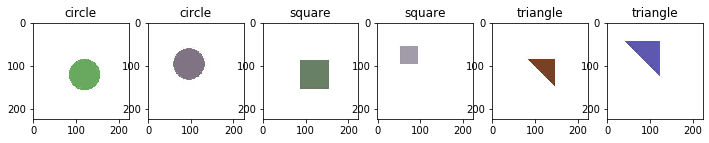

In [6]:
import os
from random import randint
import numpy as np
from PIL import Image
from matplotlib import pyplot as plt
%matplotlib inline

model_resnet.to("cpu")

# Get the list of test image files
test_folder = '../data/shapes/test'
test_image_files = os.listdir(test_folder)

# Empty array on which to store the images
image_arrays = []

size = (224,224)
background_color="white"

fig = plt.figure(figsize=(12, 8))

# Get the images and show the predicted classes
for file_idx in range(len(test_image_files)):
    img = Image.open(os.path.join(test_folder, test_image_files[file_idx]))
    
    # resize the image so it matches the training set - it  must be the same size as the images on which the model was trained
    resized_img = np.array(resize_image(img, size, background_color))
                      
    # Add the image to the array of images
    image_arrays.append(resized_img)

# Get predictions from the array of image arrays
# Note that the model expects an array of 1 or more images - just like the batches on which it was trained
predictions = predict_image(model_resnet, np.array(image_arrays))

# plot easch image with its corresponding prediction
for idx in range(len(predictions)):
    a=fig.add_subplot(1,len(predictions),idx+1)
    imgplot = plt.imshow(image_arrays[idx])
    a.set_title(predictions[idx])
